## Introduction

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Proposed Project Plan
A model will be created and trained to perform this. To achieve this, the following will be performed:
1. Download and load data
2. Explore the data and determine preprocessing steps
3. Perform data preprocessing and include steps such as:
    - Merging the data on CustomerID by left join
    - Converting specific columns to necessary data types
    - Convert column names to lower case for consistent format
    - Convert "Yes" and "No" values to "1" and "0"
    - Fill in missing values that occur due to merging 
    - Create a churn flag based on 'EndDate' as 'No' or as an actual date
    - Create a tenure feature based on the length of the customer relationship
4. Perform Exploratory Data Analysis (EDA) 
    - Explore class balance
    - Visualize relationships between churn and service usage, tenure, and monthly/total charges
    - Explore churn patterns by contract type, internet service, and customer demographics
5. Feature Engineering; create derived features such as:
    - Total number of services used
    - Payment type encoding
    - Tenure groups
6. Prepare features for modeling (encoding variables)
7. Model Development
    - Train baseline and advanced classification models 
    - Evaluate performance using AUC-ROC as the primary metric, along with accuracy and/or F1 score
    - Address class imbalance
8. Reporting
    - Document results and performance metrics
    - Provide feedback, assumptions, and limitations
    - Submit notebook for review

## 1. Download and load data

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# load datasets

try:
    contract = pd.read_csv('/System/Volumes/Data/Users/krystaltaylar/Desktop/Final Project/contract.csv')
except FileNotFoundError:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
try:
    personal = pd.read_csv('/System/Volumes/Data/Users/krystaltaylar/Desktop/Final Project/personal.csv')
except FileNotFoundError:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
try:
    internet = pd.read_csv('/System/Volumes/Data/Users/krystaltaylar/Desktop/Final Project/internet.csv')
except FileNotFoundError:
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
try:
    phone = pd.read_csv('/System/Volumes/Data/Users/krystaltaylar/Desktop/Final Project/phone.csv')
except FileNotFoundError:
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [4]:
print('Contract Shape:', contract.shape)
print('Personal Shape:', personal.shape)
print('Internet Shape:', internet.shape)
print('Phone Shape:', phone.shape)
print()
print('Contract Dataset')
display(contract.head(5))
print('Personal Dataset')
display(personal.head(5))
print('Internet Dataset')
display(internet.head(5))
print('Phone Dataset')
display(phone.head(5))

Contract Shape: (7043, 8)
Personal Shape: (7043, 5)
Internet Shape: (5517, 8)
Phone Shape: (6361, 2)

Contract Dataset


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Personal Dataset


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Internet Dataset


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Phone Dataset


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


## 2. Explore data and determine preprocessing steps

In [5]:
# checking contract dataset
display(contract.info())
display(contract.isnull().sum())
display(contract.duplicated().sum())
display(contract.duplicated('customerID').sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

0

0

The columns 'BeginDate' and 'EndDate' should be converted to datetime, only consisting of the month, day and year. The 'TotalCharges' column should be converted to float64.

In [6]:
# checking personal dataset
display(personal.info())
display(personal.isnull().sum())
display(personal.duplicated().sum())
display(personal.duplicated('customerID').sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

0

0

The 'SeniorCitizen' column should be converted to object datatype.

In [7]:
# checking internet dataset
display(internet.info())
display(internet.isnull().sum())
display(internet.duplicated().sum())
display(internet.duplicated('customerID').sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

0

0

Everything looks good here.

In [8]:
# checking phone dataset
display(phone.info())
display(phone.isnull().sum())
display(phone.duplicated().sum())
display(phone.duplicated('customerID').sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

customerID       0
MultipleLines    0
dtype: int64

0

0

Everything looks good here.

In [9]:
# balance check - active customers
len(contract[contract['EndDate'] == 'No'])/len(contract['EndDate'])

0.7346301292063041

## Notes about project 

- Based on the shape of each dataset, it is evident that the contract dataset contains the full customer base and can serve as the reference point. The personal dataset matches the contract, however, the internet and phone datasets do not. The internet dataset is missing 1526 customers and the phone dataset is missing 682 customers. This is likely due to customers that don't have internet service or phone service, respectively. This isn't necessarily a bad thing, however, when merging the datasets it's important to use left join merge on the contract dataset to keep the full customer base. For customers that don't have internet or phone service, NaN will take place there.
- 73% of customers are still active as of 2/1/2020, meaning there is class imbalance that needs to be considered during modeling. This is indicated by 'No' in the 'EndDate' column.
- The columns 'BeginDate' and 'EndDate' should be converted to datetime, only consisting of the month, day and year - timestamps will be dropped from 'Endate'.
- The 'TotalCharges' column should be converted to float64.
- The 'SeniorCitizen' column should be converted to object datatype.
- All strings in all datasets will be converted to lowercase when they are merged.

## 3. Perform preprocessing

In [10]:
# merge datasets
df = contract.merge(personal, on='customerID', how='left').merge(internet, on='customerID', how='left').merge(phone, on='customerID', how='left')

print(df.shape)
display(df.head(10))

(7043, 20)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [11]:
# convert column names to lowercase
df.columns = df.columns.str.lower()

# convert column values to lowercase, remove white space
for col in df.select_dtypes(include=['object', 'category']).columns:
    df[col] = df[col].astype(str).str.strip().str.lower()
df.replace('nan', np.nan, inplace=True)

# convert begindate and enddate columns to datetime and remove timestamp from enddate
df['begindate'] = pd.to_datetime(df['begindate'])
df['enddate'] = pd.to_datetime(df['enddate'], errors='coerce')

# Create churn flag: 1 = churned, 0 = active
df['churn'] = df['enddate'].notna().astype(int)

#convert totalcharges to float
df['totalcharges'] = df['totalcharges'].replace(r'^\s*$', np.nan, regex=True).astype(float)
df['totalcharges'] = df['totalcharges'].fillna(0)

# convert seniorcitizen to object
df['seniorcitizen'] = df['seniorcitizen'].astype('object')

# fill missing service features with 'no'
internet_cols = ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']
df[internet_cols] = df[internet_cols].fillna('no')

df['multiplelines'] = df['multiplelines'].fillna('no')


# Convert binary yes/no columns to 1/0
def set_binary_dtype(df, cols, to='category'):
    if to == 'category':
        df[cols] = df[cols].replace({1: 'yes', 0: 'no'}).astype('category')
    elif to == 'int':
        for col in cols:
            df[col] = df[col].astype(str).str.strip().str.lower()
            df[col] = df[col].replace({'yes': 1, 'no': 0, 'nan': np.nan})
            df[col] = df[col].astype(float).fillna(0).astype(int)
        
binary_cols = ['partner', 'dependents', 'paperlessbilling', 'multiplelines',
               'onlinesecurity', 'onlinebackup', 'deviceprotection', 
               'techsupport', 'streamingtv', 'streamingmovies']
df[binary_cols] = df[binary_cols].replace({'yes': 1, 'no': 0}).astype('category')


# Calculate tenure in months
as_of_date = pd.to_datetime('2020-02-01')
df['tenure_days'] = (df['enddate'].fillna(as_of_date) - df['begindate']).dt.days
df['tenure_months'] = (df['tenure_days'] / 30).round().astype(int)

In [12]:
display(df.head(20))
print(df.info())

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,churn,tenure_days,tenure_months
0,7590-vhveg,2020-01-01,NaT,month-to-month,1,electronic check,29.85,29.85,female,0,...,0,1,0,0,0,0,0,0,31,1
1,5575-gnvde,2017-04-01,NaT,one year,0,mailed check,56.95,1889.50,male,0,...,1,0,1,0,0,0,0,0,1036,35
2,3668-qpybk,2019-10-01,2019-12-01,month-to-month,1,mailed check,53.85,108.15,male,0,...,1,1,0,0,0,0,0,1,61,2
3,7795-cfocw,2016-05-01,NaT,one year,0,bank transfer (automatic),42.30,1840.75,male,0,...,1,0,1,1,0,0,0,0,1371,46
4,9237-hqitu,2019-09-01,2019-11-01,month-to-month,1,electronic check,70.70,151.65,female,0,...,0,0,0,0,0,0,0,1,61,2
5,9305-cdskc,2019-03-01,2019-11-01,month-to-month,1,electronic check,99.65,820.50,female,0,...,0,0,1,0,1,1,1,1,245,8
6,1452-kiovk,2018-04-01,NaT,month-to-month,1,credit card (automatic),89.10,1949.40,male,0,...,0,1,0,0,1,0,1,0,671,22
7,6713-okomc,2019-04-01,NaT,month-to-month,0,mailed check,29.75,301.90,female,0,...,1,0,0,0,0,0,0,0,306,10
8,7892-pookp,2017-07-01,2019-11-01,month-to-month,1,electronic check,104.80,3046.05,female,0,...,0,0,1,1,1,1,1,1,853,28
9,6388-tabgu,2014-12-01,NaT,one year,0,bank transfer (automatic),56.15,3487.95,male,0,...,1,1,0,0,0,0,0,0,1888,63


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1869 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   category      
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   seniorcitizen     7043 non-null   object        
 10  partner           7043 non-null   category      
 11  dependents        7043 non-null   category      
 12  internetservice   7043 non-null   object        
 13  onlinesecurity    7043 non-null   category      
 14  onlinebackup      7043 n

## 4. EDA

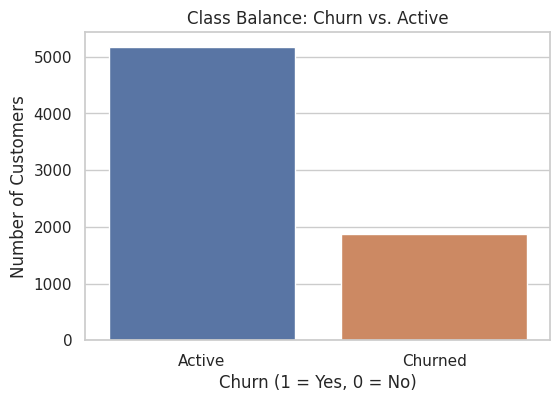

In [13]:
sns.set(style="whitegrid")

# 1. Class Balance: Churned vs Active
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=df)
plt.title('Class Balance: Churn vs. Active')
plt.xlabel('Churn (1 = Yes, 0 = No)')
plt.ylabel('Number of Customers')
plt.xticks([0, 1], ['Active', 'Churned'])
plt.show()

As mentioned before, there is a class imbalance. This is visualized by the above graph, showing majority of customers as of 2/1/2020 are still active.

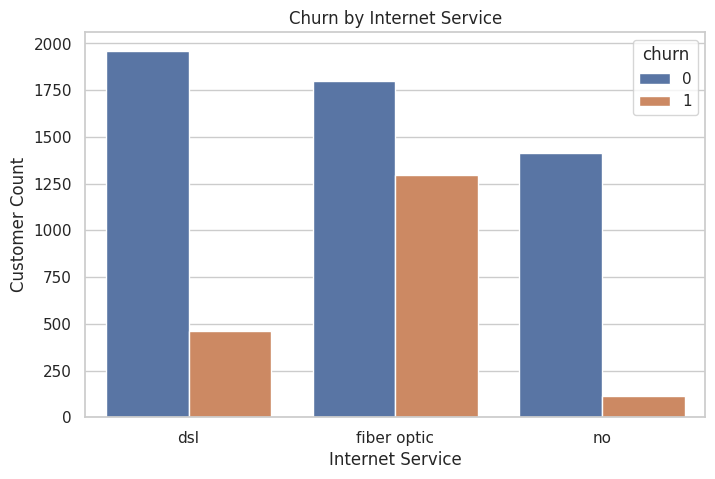

In [14]:
# 2. Churn by Internet Service
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='internetservice', hue='churn')
plt.title('Churn by Internet Service')
plt.xlabel('Internet Service')
plt.ylabel('Customer Count')
plt.show()

Based on the graph above, majority of churned customers had Fiber optic for internet service. It would be interesting to further dive into the characteristics of those clients who typically have this service.

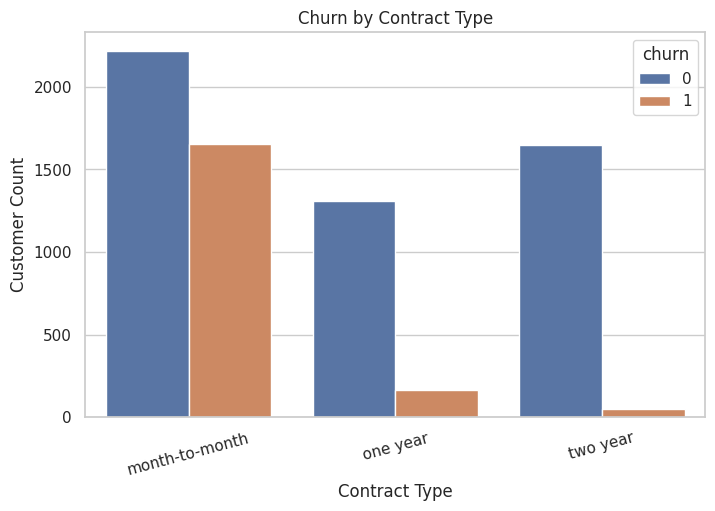

In [15]:
# 3. Churn by Contract Type
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='type', hue='churn')
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Customer Count')
plt.xticks(rotation=15)
plt.show()

Based on the above graph, customers with a month-to-month contract type are more likely to churn versus those with one year or two year contracts. Oddly enough, the majority of active customers are also month-to-month.

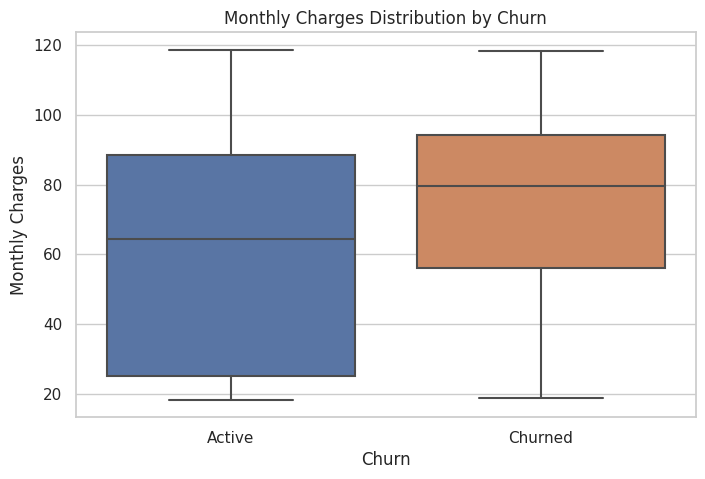

In [16]:
# 4. Monthly Charges by Churn
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='churn', y='monthlycharges')
plt.title('Monthly Charges Distribution by Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.xticks([0, 1], ['Active', 'Churned'])
plt.show()

The boxplots above show the following:
- Churned customers have a higher median monthly charge than active, suggesting that churned customers were paying more monthly on average.
- The box is taller for churned customers, indicating more variability in monthly charges.
- Active customers have a lower spread and a more concentrated set of lower monthly charges.
- Both groups have similar minimums and maximums - around $18-$118.

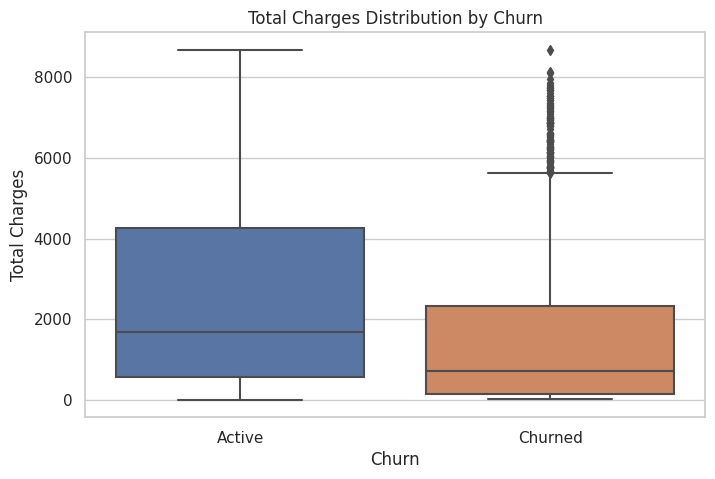

In [17]:
# 5. Total Charges by Churn
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='churn', y='totalcharges')
plt.title('Total Charges Distribution by Churn')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.xticks([0, 1], ['Active', 'Churned'])
plt.show()

The boxplots above show the following:
- Active customers have a much higher median total charge than churned customers, which is to be expected as it suggests churned customers left earlier before accumulating higher bills.
- There are visibile outliers among churned customers, with total charges exceeding $6k-$8k. This is likely due to customers who churned after a longer tenure of service.

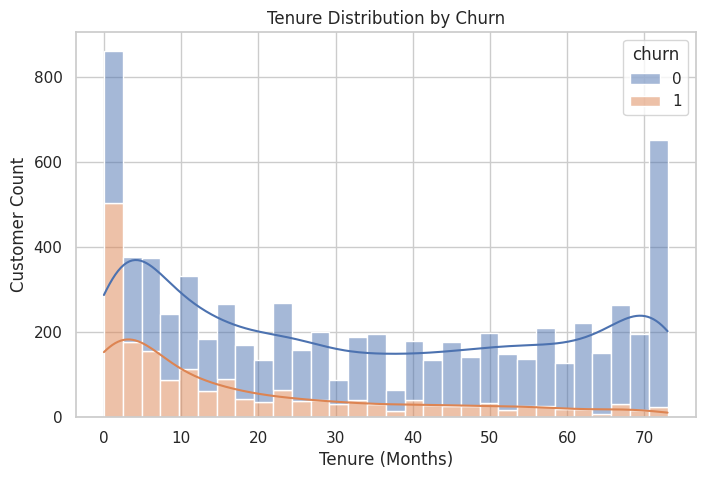

In [18]:
# 6. Tenure by Churn
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='tenure_months', hue='churn', bins=30, kde=True, multiple='stack')
plt.title('Tenure Distribution by Churn')
plt.xlabel('Tenure (Months)')
plt.ylabel('Customer Count')
plt.show()

This graph reveals that majority of churned customers do so before 12 months, with many churning within a month or two of service. As expected, the customers with the longest tenure are still active. There are still some customers who had a long tenure and churned after such a long time.

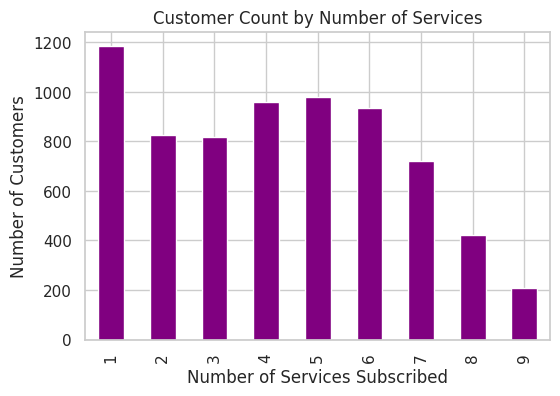

In [19]:
# 7. Customer count by number of services 

set_binary_dtype(df, binary_cols, to='int')

df['has_internet'] = df['internetservice'].apply(lambda x: 0 if x == 'no' else 1)
df['has_phone'] = df['multiplelines'].apply(lambda x: 1 if x in [0, 1] else 0)


service_cols = ['has_phone', 'has_internet', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 
                'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']

df['num_services'] = df[service_cols].sum(axis=1)

df['num_services'].value_counts().sort_index().plot(kind='bar', color='purple', figsize=(6,4), title='Customer Count by Number of Services')
plt.xlabel('Number of Services Subscribed')
plt.ylabel('Number of Customers')
plt.show()

The graph reveals that majority of customers are subbscribed to one service. These are users who only have a basic landline.

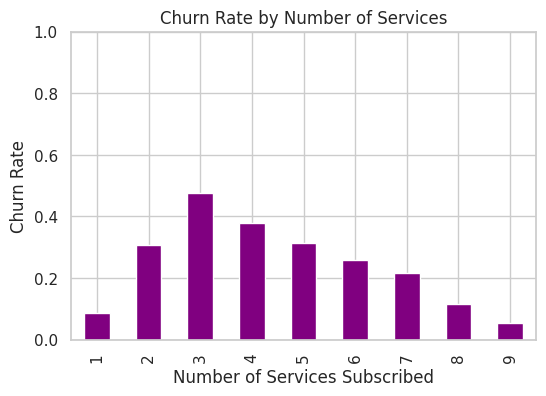

In [20]:
# 8. Churn rate by number of services

services_churn = df.groupby('num_services')['churn'].mean()

services_churn.plot(kind='bar', color='purple', figsize=(6,4), title='Churn Rate by Number of Services')
plt.ylabel('Churn Rate')
plt.xlabel('Number of Services Subscribed')
plt.ylim(0, 1)
plt.show()

The graph reveals the churn rate is highest for customers subscribed to three services. The lowest churn rate is for customers with one or nine services.

## 5. Feature Engineering

Some additional features were already derived above. Tenure groups will be defined, however, tenure_months already provides quite clear insight into early churn behavior. Tenure_group will likely mirror this, but will still be included to follow along with my project plan.

In [21]:
# create Tenure groups
def tenure_group(months):
    if months < 12:
        return '0-11 months'
    elif months < 24:
        return '12-23 months'
    elif months < 48:
        return '24-47 months'
    else:
        return '48+ months'

df['tenure_group'] = df['tenure_months'].apply(tenure_group)
df['tenure_group'] = pd.Categorical(
    df['tenure_group'],
    categories=['0-11 months', '12-23 months', '24-47 months', '48+ months'],
    ordered=True
)

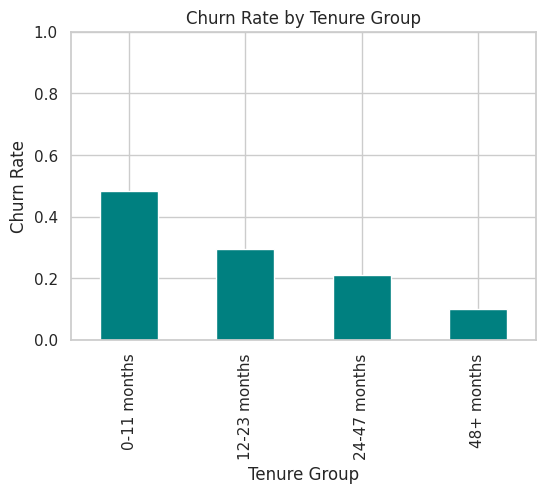

In [22]:
tenure_churn = df.groupby('tenure_group')['churn'].mean()

tenure_churn.plot(kind='bar', color='teal', title='Churn Rate by Tenure Group', figsize=(6, 4))
plt.ylabel('Churn Rate')
plt.xlabel('Tenure Group')
plt.ylim(0, 1)
plt.show()

In [23]:
# one-hot encoding for payment method

df = pd.get_dummies(df, columns=['paymentmethod'], prefix='paytype')

## 6. Prepare features for model

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   customerid                         7043 non-null   object        
 1   begindate                          7043 non-null   datetime64[ns]
 2   enddate                            1869 non-null   datetime64[ns]
 3   type                               7043 non-null   object        
 4   paperlessbilling                   7043 non-null   int64         
 5   monthlycharges                     7043 non-null   float64       
 6   totalcharges                       7043 non-null   float64       
 7   gender                             7043 non-null   object        
 8   seniorcitizen                      7043 non-null   object        
 9   partner                            7043 non-null   int64         
 10  dependents                         7

In [25]:
# establish features and target
target = df['churn']
features = df.drop(['churn', 'customerid', 'begindate', 'enddate'], axis=1)

In [26]:
# split data into training and validation sets
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

# split validation set into validation and test sets
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=12345)

In [27]:
# get categorical columns from training data
categorical_cols = features_train.select_dtypes(include=['object', 'category']).columns.tolist()

# encode each split separately
features_train_enc = pd.get_dummies(features_train, columns=categorical_cols, drop_first=True)
features_valid_enc = pd.get_dummies(features_valid, columns=categorical_cols, drop_first=True)
features_test_enc = pd.get_dummies(features_test, columns=categorical_cols, drop_first=True)

# align all features
features_train_enc, features_valid_enc = features_train_enc.align(features_valid_enc, join='left', axis=1, fill_value=0)
features_train_enc, features_test_enc = features_train_enc.align(features_test_enc, join='left', axis=1, fill_value=0)

features_train_enc = features_train_enc.astype(int)
features_valid_enc = features_valid_enc.astype(int)
features_test_enc = features_test_enc.astype(int)

## 7. Model Development
Create sanity check with baseline model (Logistic Regression), and train other models.
Only Logistic Regression will received scaled data.

In [28]:
# initialize StandardScaler
scaler = StandardScaler()

# scale numerical features
features_train_scaled = scaler.fit_transform(features_train_enc)
features_valid_scaled = scaler.transform(features_valid_enc)

log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=12345)
log_reg.fit(features_train_scaled, target_train)

preds = log_reg.predict(features_valid_scaled)
probs = log_reg.predict_proba(features_valid_scaled)[:, 1]

# Evaluate
print("Baseline Logistic Regression:")
print("Accuracy:", accuracy_score(target_valid, preds))
print("F1 Score:", f1_score(target_valid, preds))
print("AUC-ROC:", roc_auc_score(target_valid, probs))

Baseline Logistic Regression:
Accuracy: 0.7670454545454546
F1 Score: 0.6507666098807496
AUC-ROC: 0.8517239554391257


In [29]:
# create function for evaluating each model

def evaluate_model(model, name, features_train, features_valid, target_train, target_valid):
    model.fit(features_train, target_train)
    preds = model.predict(features_valid)
    probs = model.predict_proba(features_valid)[:, 1]

    print(f"\n{name}")
    print("Accuracy:", accuracy_score(target_valid, preds))
    print("F1 Score:", f1_score(target_valid, preds))
    print("AUC-ROC:", roc_auc_score(target_valid, probs))

In [30]:
gbc = GradientBoostingClassifier(random_state=12345)

evaluate_model(gbc, "GradientBoostingClassifier", 
               features_train_enc, features_valid_enc, 
               target_train, target_valid)


GradientBoostingClassifier
Accuracy: 0.8613636363636363
F1 Score: 0.708133971291866
AUC-ROC: 0.8984976581725808


In [31]:
# Combine features and target into one DataFrame
train_df = pd.concat([pd.DataFrame(features_train_enc), pd.Series(target_train, name='target')], axis=1)

# Separate majority and minority classes
majority = train_df[train_df.target == 0]
minority = train_df[train_df.target == 1]

# Upsample minority class
minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),  # Match majority class
    random_state=12345
)

# Combine and shuffle
train_balanced = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=12345)

# Final split
features_train_bal = train_balanced.drop('target', axis=1).values
target_train_bal = train_balanced['target'].values

In [32]:
gbc_param_grid = {
    'n_estimators': [100, 200, 300],      
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0]
}

gbc_search = RandomizedSearchCV(
    gbc,
    gbc_param_grid,
    n_iter=5,
    scoring='roc_auc',
    cv=3,
    random_state=12345,
    n_jobs=-1,
    verbose=1
)

gbc_search.fit(features_train_bal, target_train_bal)

print("Best GBC Parameters:", gbc_search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best GBC Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1}


In [33]:
gbc_tuned = GradientBoostingClassifier(
    random_state=12345,
    n_estimators=300,        # Fill these in
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8
)

evaluate_model(
    gbc_tuned,
    "GradientBoostingClassifier (Tuned)",
    features_train_bal,
    features_valid_enc,
    target_train_bal,
    target_valid
)


GradientBoostingClassifier (Tuned)
Accuracy: 0.8488636363636364
F1 Score: 0.73558648111332
AUC-ROC: 0.914887142441322


In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=12345)
evaluate_model(xgb, "XGBoostClassifier",
               features_train_enc, features_valid_enc, 
               target_train, target_valid)

In [ ]:
xgb_params = {
    'n_estimators': [200, 300],
    'max_depth': [4, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.9, 1],
    'colsample_bytree': [0.7, 0.9]
}

search_xgb = RandomizedSearchCV(
    xgb,
    xgb_params,
    n_iter=5,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=1,
    random_state=12345
)

search_xgb.fit(features_train_bal, target_train_bal)
print("Best XGB Parameters:", search_xgb.best_params_)

In [ ]:
xgb_tuned = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=12345,
    colsample_bytree=0.9,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=300,
    subsample=1
)

# Evaluate the tuned model
evaluate_model(
    xgb_tuned,
    "XGBoostClassifier (Tuned)",
    features_train_bal,
    features_valid_enc,
    target_train_bal,
    target_valid
)

In [ ]:
lgbm = LGBMClassifier(random_state=12345)
evaluate_model(lgbm, "LightGBMClassifier",
               features_train_enc, features_valid_enc, 
               target_train, target_valid)

In [ ]:
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 4, 6],
    'subsample': [0.8, 1.0]
}

lgbm_search = RandomizedSearchCV(
    lgbm,
    lgbm_param_grid,
    n_iter=5,
    scoring='roc_auc',
    cv=3,
    random_state=12345,
    n_jobs=-1,
    verbose=1
)

lgbm_search.fit(features_train_bal, target_train_bal)

print("Best LGBM Parameters:", lgbm_search.best_params_)

In [ ]:
lgbm_tuned = LGBMClassifier(
    random_state=12345,
    n_estimators=300,      # Fill in
    learning_rate=0.1,
    max_depth=-1,
    subsample=0.8
)

evaluate_model(
    lgbm_tuned,
    "LightGBMClassifier (Tuned)",
    features_train_bal,
    features_valid_enc,
    target_train_bal,
    target_valid
)

In [ ]:
catboost = CatBoostClassifier(verbose=0, random_state=12345)
evaluate_model(catboost, "CatBoostClassifier",
               features_train_enc, features_valid_enc, 
               target_train, target_valid)

In [ ]:
catboost_param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1]
}

catboost_search = RandomizedSearchCV(
    catboost,
    catboost_param_grid,
    n_iter=5,
    scoring='roc_auc',
    cv=3,
    random_state=12345,
    n_jobs=-1,
    verbose=1
)

catboost_search.fit(features_train_bal, target_train_bal)

print("Best CatBoost Parameters:", catboost_search.best_params_)

In [ ]:
catboost_tuned = CatBoostClassifier(
    verbose=0,
    random_state=12345,
    iterations=200,      # Fill in
    depth=8,
    learning_rate=0.1
)

evaluate_model(
    catboost_tuned,
    "CatBoostClassifier (Tuned)",
    features_train_bal,
    features_valid_enc,
    target_train_bal,
    target_valid
)

The results of each model before tuning were pretty decent and after addressing class imbalance and tuning hyperparameters, the metrics were still optimal. However, there was a slight decrease in the metrics for XGBoost and CatBoost.

Overall, LightGBM had the best AUC-ROC metric. While all three metrics for GradientBoosting were the best altogether.

## 7.1 Final Model Testing

In [ ]:
# create function for model testing
def evaluate_model_test(model, name, features_test, target_test, plot_roc=False):
    preds = model.predict(features_test)
    probs = model.predict_proba(features_test)[:, 1]

    print(f"\n{name} (Test Evaluation)")
    print("Accuracy:", accuracy_score(target_test, preds))
    print("F1 Score:", f1_score(target_test, preds))
    print("AUC-ROC:", roc_auc_score(target_test, probs))

    if plot_roc:
        fpr, tpr, _ = roc_curve(target_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

In [ ]:
# evaluate each model

plt.figure(figsize=(10, 7))

features_test_scaled = scaler.transform(features_test_enc)
evaluate_model_test(log_reg, "Logistic Regression", features_test_scaled, target_test, plot_roc=True)

evaluate_model_test(gbc_tuned, "GradientBoostingClassifier", features_test_enc, target_test, plot_roc=True)

evaluate_model_test(xgb_tuned, "XGBoost", features_test_enc, target_test, plot_roc=True)

evaluate_model_test(lgbm_tuned, "LightGBM", features_test_enc, target_test, plot_roc=True)

evaluate_model_test(catboost_tuned, "CatBoost", features_test_enc, target_test, plot_roc=True)

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 8. Conclusion
The goal of this project was to build a machine learning model capable of accurately predicting customer churn for Interconnect, a telecom provider. After thorough data preprocessing, exploratory analysis, and feature engineering, several models were developed and evaluated using accuracy, F1 score, and AUC-ROC as key performance metrics.

While all models performed better than the baseline, GradientBoosting Classifier, XGBoost and LightGBM performed the best with very similar AUC-ROC scores. LightGBM has a higher Accuracy and F1 Score, but only slightly. The higher AUC-ROC score indicates strong discriminatory power between churned and retained customers.

Based on the results, GradientBoostingClassifier, XGBoost or LightGBM would be well-suited for production deployment, depending on business priorities.

XGBoost did run the slowest and require additional changes to the hyperparameter search, a downfall I would say would encourage me not to use it for this project.

### Feedback, Assumptions, and Limitations
This project benefited from a well-structured and mostly clean dataset, which streamlined preprocessing and model development. The target variable, churn, was reliably extracted from the EndDate field, and categorical service features were logically obtained based on domain understanding.

Several assumptions were made during the modeling process. Customers with a missing EndDate were assumed to still be active as of the reference date (February 1, 2020). Missing values in service-related columns were treated as an indication that the customer did not subscribe to the service in question. Tenure was calculated based on the difference between BeginDate and either EndDate or the reference date, assuming continuous service throughout that time. Class imbalance (~27% churn rate) was addressed using the class_weight='balanced' parameter and SMOTE during hyperparameter tuning, under the assumption that synthetic sampling would improve generalization.

Despite these strengths, the project had some limitations. The data represents a single point in time. External factors such as customer demographics, location, or socioeconomic data were unavailable, which limited the feature space. While categorical variables were encoded appropriately, some service-related features may still carry multicollinearity, especially in models that don’t handle it naturally.

# Solution Report

### 1. Project Objective

The objective of this project was to develop a predictive model that accurately identifies customers likely to churn from Interconnect, a telecom service provider. I was provided multiple datasets to review and create a plan to assess customer churn with the goal of enabling proactive customer retention strategies, reducing revenue loss, and improving customer satisfaction.

### 2. Summary of Actions Taken

##### Steps Performed:
- Data cleaning and preprocessing: Included conversion of date fields, calculation of tenure, handling of missing values, and creation of relevant categorical indicators.
- Exploratory data analysis: Identified key trends and correlations between customer behavior and churn.
- Feature engineering: Constructed variables such as total services, contract type, and payment behavior.
- Handling class imbalance: Employed class_weight='balanced' for Logistic Regression and manual upsampling for all tree-based models.
- Model training and tuning: Developed and optimized five models (Logistic Regression, Gradient Boosting, XGBoost, LightGBM, CatBoost) using cross-validation and hyperparameter search.
- Model evaluation: Assessed models using accuracy, F1 score, and AUC-ROC metrics on a separate test set.
- Visualization: Developed plots to explain churn patterns related to payment methods and senior citizen demographics.
  
None of my steps were skipped from my project plan.

### 3. Key Difficulties and Resolutions

##### Class imbalance
- Resolution: Used class weighting and manual upsampling to ensure the models learned from minority churned cases.
##### Library limitations on platform
- Resolution: Replaced unavailable SMOTE technique with custom upsampling logic using pandas and sklearn.
##### XGBoost performance lag
- Resolution: Reduced hyperparameter search iterations and cross-validation folds to maintain reasonable execution time.

### 4. Key Steps in Solving the Task

I designed a reliable pipeline to extract and clean customer data. Categorical variables were appropriately encoded, and numerical features were scaled where necessary to support model performance. To address class imbalance, I implemented manual upsampling of churned customers specifically for training tree-based models. I then built and validated five machine learning models—Logistic Regression, Gradient Boosting, XGBoost, LightGBM, and CatBoost—comparing their performance across accuracy, F1 score, and AUC-ROC metrics. Based on this evaluation, I selected the best-performing models using the test dataset. In parallel, I conducted data analysis to uncover actionable insights into churn behavior and visualized key relationships between churn, tenure, monthly charges, subscriptions, internet service, and contract type to support strategic business recommendation.

### 5. Final Model and Results

The final selected model was the LightGBMClassifier, which demonstrated the highest overall performance on the test set.

Test Set Performance:

Model	           Accuracy	 F1 Score	AUC-ROC
Logistic Regression	0.717	 0.602	   0.830
Gradient Boosting	0.824	 0.702	   0.889
XGBoost	            0.810	 0.679	   0.884
LightGBM (Final)	0.846	 0.721	   0.901
CatBoost	        0.796	 0.639	   0.859
LightGBM has the best metrics. It also had an efficient training time and strong ability to handle feature interactions. Thought Logistic regression performed the lowest, it's AUC-ROC score is still optimal and it has the fastest training time being that it is the baseline.

### 6. Business Insights: Drivers of Churn

Through analysis of the dataset, several patterns were found among customers who churned:

- Tenure: Customers were more likely to churn in the first 12 months of service.
- Monthly Charges: Churned customers had higher average monthly bills.
- Internet Type: Churn was significantly higher among fiber optic internet users compared to DSL or customers with no internet service.
- Contract Type: Customers on month-to-month contracts churned at much higher rates than those with annual agreements.
- Service Usage: Churn increased as customers added services, peaking at around 3 services. Churn then decreased for customers with 4 or more services.

### 7. Additional insights not previously included

During my analysis, I didn't assess senior customers nor payment method, so I'd like to include an assessment here as well.

In [ ]:
# Churn rate by payment type
paytype_cols = [
    'paytype_bank transfer (automatic)',
    'paytype_credit card (automatic)',
    'paytype_electronic check',
    'paytype_mailed check'
]
df['payment_type'] = df[paytype_cols].idxmax(axis=1).str.replace('paytype_', '')

payment_churn = df.groupby('payment_type')['churn'].mean().sort_values(ascending=False)

sns.barplot(x=payment_churn.index, y=payment_churn.values)
plt.title('Churn Rate by Payment Type')
plt.ylabel('Churn Rate')
plt.xlabel('Payment Type')
plt.xticks(rotation=45)
plt.show()

# Monthly charges charges by senior status and churn
df['seniorcitizen'] = df['seniorcitizen'].astype(int)

sns.boxplot(data=df, x='seniorcitizen', y='monthlycharges', hue='churn')
plt.title('Monthly Charges by Senior Citizen Status and Churn')
plt.xlabel('Senior Citizen (0 = No, 1 = Yes)')
plt.ylabel('Monthly Charges')
plt.legend(title='Churn')
plt.show()

- Payment Method: Customers who used electronic checks had the highest churn rates, suggesting potential billing or engagement issues. This suggests a strong correlation between manual, non-recurring payment methods and higher churn likelihood. One possible interpretation is that customers who actively manage monthly payments may feel less committed to the service or are more sensitive to billing issues. In contrast, customers on automated payments may be more engaged or experience less friction in billing.

- Senior Citizens: Senior customers had higher average monthly charges, and a notable churn rate compared to non-senior customers. Non-senior customers who churned also show higher charges than those who stayed, but the difference is more pronounced in the senior group.

### 8. Recommendations for Interconnect Telecom

Based on the findings from this project, several targeted strategies are recommended to reduce churn and improve customer retention. First, retention campaigns should prioritize outreach to customers in their first year of service, particularly those on month-to-month contracts, as they have been identified as having a higher likelihood of churn. Second, Interconnect should consider offering tailored discounts or bundled service incentives to customers subscribed to one to three services and those using fiber optic internet, as these groups exhibited elevated churn rates. Additionally, implementing price-sensitive plans or enhanced customer service programs for senior citizens may help address the higher monthly charges observed within this segment, which could be contributing to churn. Lastly, the company should promote automated payment methods such as bank transfers or credit card auto-pay, as customers paying by electronic check were found to churn at a significantly higher rate. These efforts, if implemented, may enhance customer satisfaction and reduce attrition.